In [1]:
import pandas as pd
from pymer4.models import Lmer
from core.analysis import *

/anaconda3/envs/bert/lib/python3.7/site-packages/rpy2/robjects/vectors.py:969: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


<Figure size 432x288 with 0 Axes>

## Data Prep

In [2]:
db = access_db()


In [3]:
trials = get_trial_data(db)
participants = get_participant_data(db)
user_data = participants[(participants['completedTask'] == 1) & (participants.index > 4) 
                         & ~(participants['workerID'].str.startswith("pilot"))] #excluding my data/Jon/Stephan
results = trials[trials['userID'].isin(user_data['userID'])]
users = user_data['userID']

## Consistency

In [4]:
repeat_corr = all_repeats(results, users, plot = False) #self correlation
shared_results = results[results['trialType'] == 'shared']
shared_corrs = group_consistency(shared_results, users) #shared correlation
user_time_word_changes = get_time_and_changes(results, user_data) #metadata
consistency = pd.DataFrame({'Group Consistency': shared_corrs, 'Self Consistency': repeat_corr})
corrs = user_time_word_changes.merge(consistency, on = user_time_word_changes.index).drop('key_0', axis = 1)
corrs['Correlation with SN'] = my_correlations(participants, trials, results, users) #vs gold standard

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


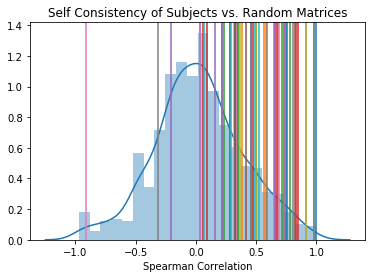

In [19]:
random_self = simulate_self_correlation(1000, db)


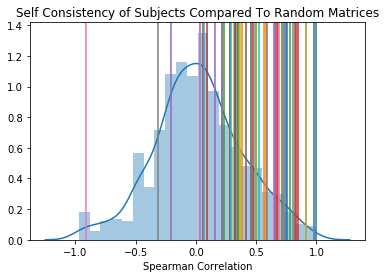

In [25]:
plot_consistency_hist(random_self, corrs['Self Consistency'], 
                      "Self Consistency of Subjects Compared To Random Matrices", legend = False)

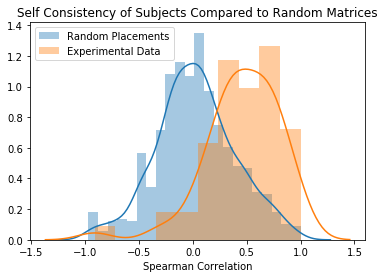

In [31]:
sns.distplot(random_self, label = "Random Placements")
sns.distplot(corrs['Self Consistency'], label = "Experimental Data")
plt.title("Self Consistency of Subjects Compared to Random Matrices")
plt.xlabel("Spearman Correlation")
plt.legend()
plt.savefig("../../results/figures/self_consistency.png")

In [11]:
sns.distplot(random_group, label = "Random Placements")
sns.distplot(corrs['Group Consistency'], label = "Experimental Data")
plt.title("Group Consistency of Subjects Compared to Random Matrices")
plt.xlabel("Spearman Correlation")
plt.legend()
plt.savefig("../../results/figures/group_consistency.png")

NameError: name 'random_group' is not defined

In [3]:
len(corrs[corrs['Self Consistency'] > 0.2])

NameError: name 'corrs' is not defined

In [17]:
len(corrs[corrs['Group Consistency'] > 0.4])

43

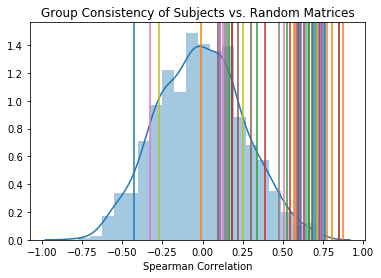

In [8]:
random_group = [random_vs_all(shared_results) for _ in range(1000)]
plot_consistency_hist(random_group, corrs['Group Consistency'], 
                      "Group Consistency of Subjects vs. Random Matrices", legend = False)

Exclusion criteria: Self below 0.2?

In [9]:
len(corrs[corrs['Self Consistency'] > 0.2])

27

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


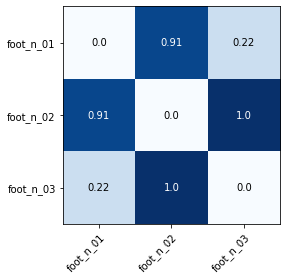

In [63]:
m, s = get_subject_mtx(results, '-M4zwU5ri8CH5Mqr_WVJ', 'foot_n', 'shared')
im = plt.imshow(m)
ax = plt.axes()
annotate_mtx(m, im, ax, s, write_text = True)

## MDS

Applying our exclusion criteria

In [166]:
participants[participants['workerID'] == '7143'] #Used English less than 50% of the time

,userID,workerID,userIP,completedTask,timeTaken
165,-M6Cl_rmTwH43zEQtJcK,7143,1663454401,1,1272.243


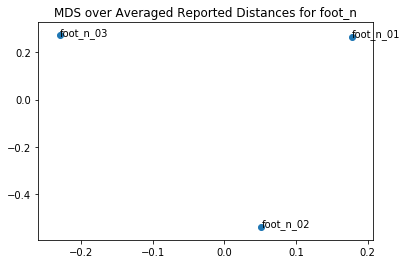

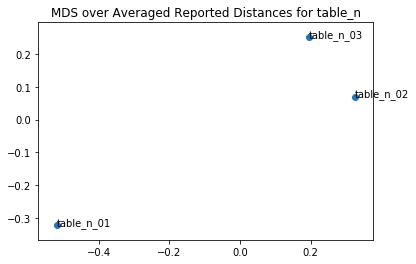

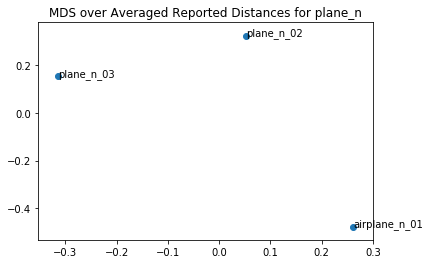

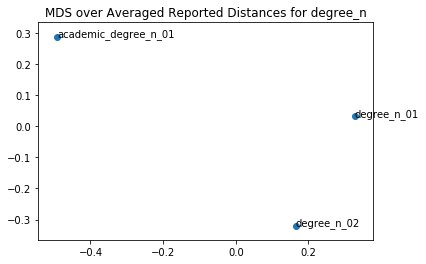

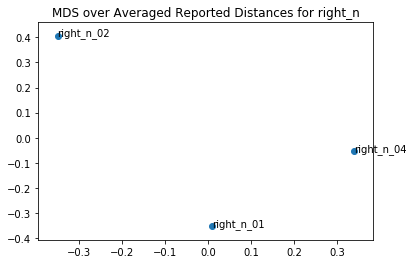

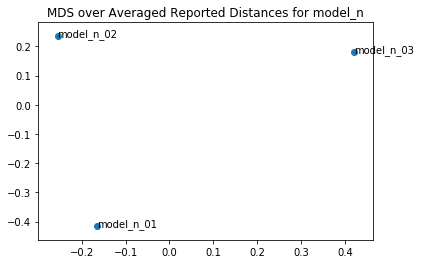

In [6]:
min_time = corrs.drop('userID', axis = 1).apply(np.mean)['timeTaken'] - corrs.drop('userID', axis = 1).apply(np.std)['timeTaken']
incl_users = corrs[(corrs['timeTaken'] > min_time) & ((corrs['Group Consistency'] > 0.4) | (corrs['Self Consistency'] > 0.2))]['userID']
incl_users = incl_users.tolist()
incl_users.remove('-M6Cl_rmTwH43zEQtJcK')
plot_all_mds(results, incl_users, 'shared', db)

In [19]:
test_defs = display_sense_definitions(results, 'shared')
test_defs.drop("Type", axis = 1, inplace = True)
test_defs.to_csv("../data/shared_defs.csv", index = False)

In [64]:
all_shared_defs = display_sense_definitions(results, 'shared')

In [71]:
all_shared_defs[all_shared_defs['Type'] == 'degree_n']

,Sense,Type,Definition
221,academic_degree_n_01,degree_n,an award conferred by a college or university signifying that the recipient has satisfactorily completed a course of study
222,degree_n_01,degree_n,a position on a scale of intensity or amount or quality
223,degree_n_02,degree_n,a specific identifiable position in a continuum or series or especially in a process


## Test Trials

Number of trials we got for each test/repeat word

In [73]:
test_data = results[(results['userID'].isin(incl_users)) & (results['trialType'].isin(['test', 'repeat']))]
lemma_counts = test_data['lemma'].value_counts()
lemma_counts / [get_num_senses(l, db) for l in lemma_counts.index]

world_n       47.0
life_n        38.0
cover_v       39.0
time_n        38.0
consider_v    37.0
lead_v        26.0
case_n        40.0
death_n       40.0
face_n        38.0
indicate_v    37.0
raise_v       37.0
point_n       29.0
way_n         29.0
area_n        46.0
door_n        45.0
ask_v         41.0
drive_v       30.0
put_v         40.0
heart_n       39.0
begin_v       38.0
school_n      38.0
produce_v     37.0
glass_n       35.0
man_n         26.0
book_n        30.0
light_n       30.0
Name: lemma, dtype: float64

In [77]:
test_data

,trialID,userID,trialIndex,trialType,prevChanged,lemma,sense,x,y
230,-M3pWJQTK1-e4buDrt_z,-M3pVTw9ili6muvdZKg4,9,test,0,put_v,frame_v_04,329.0,418.0
231,-M3pWJQTK1-e4buDrt_z,-M3pVTw9ili6muvdZKg4,9,test,0,put_v,put_v_01,467.0,433.0
232,-M3pWJQTK1-e4buDrt_z,-M3pVTw9ili6muvdZKg4,9,test,0,put_v,put_v_02,606.0,428.0
233,-M3pWSr8Z1gNbwzeclx2,-M3pVTw9ili6muvdZKg4,10,test,0,heart_n,heart_n_01,329.0,398.0
234,-M3pWSr8Z1gNbwzeclx2,-M3pVTw9ili6muvdZKg4,10,test,0,heart_n,heart_n_02,457.0,397.0
...,...,...,...,...,...,...,...,...,...
7162,-M6IAxwq3r0OG9EICVAD,-M6Dl3TeU_0klb-UCDEm,17,repeat,2,death_n,death_n_03,435.0,339.0
7163,-M6IAxwq3r0OG9EICVAD,-M6Dl3TeU_0klb-UCDEm,17,repeat,2,death_n,death_n_04,462.0,303.0
7164,-M6IB1k-bo_M5Bcg7vDu,-M6Dl3TeU_0klb-UCDEm,18,repeat,1,put_v,frame_v_04,463.0,409.0
7165,-M6IB1k-bo_M5Bcg7vDu,-M6Dl3TeU_0klb-UCDEm,18,repeat,1,put_v,put_v_01,400.0,301.0


In [124]:
lemmas = lemma_counts.index.tolist()
all_matrices = {l: [] for l in lemmas}
for l in lemmas:
    word_data = test_data[test_data['lemma'] == l]
    test_users = word_data[word_data['trialType'] == 'test']['userID']
    repeat_users = word_data[word_data['trialType'] == 'repeat']['userID']
    for u in test_users:
        u_mtx, _ = get_subject_mtx(word_data, u, l, 'test')
        all_matrices[l].append(u_mtx)
    for u in repeat_users:
        u_mtx, get_subject_mtx(word_data, u, l, 'repeat')
        all_matrices[l].append(u_mtx)


In [11]:
test_corrs = []
flatten = lambda l: [item for sublist in l for item in sublist]

for _ in range(1000):
    half_1 = []
    half_2 = []
    for l in all_matrices:
        word_responses = np.array(all_matrices[l])
        n = len(word_responses)
        if n % 2 == 1:
            drop_one = np.random.choice(np.arange(n), n - 1, replace=False)
            word_responses = word_responses[drop_one]
        n = len(word_responses)
        half = int(n / 2)
        shuffled_indices = np.random.choice(np.arange(n), n, replace = False)
        half_1 += list(np.mean(word_responses[shuffled_indices[:half]], axis = 0))
        half_2 += list(np.mean(word_responses[shuffled_indices[half:]], axis = 0))
    test_corrs.append(mtx_correlation(half_1, half_2, method = 'spearman'))
    print(test_corrs)

NameError: name 'all_matrices' is not defined

In [140]:
shared_matrices = {l: [] for l in ['degree_n', 'plane_n', 'table_n', 'foot_n', 'right_n', 'model_n']}
for l in shared_matrices.keys():
    word_data = results[results['lemma'] == l]
    users = word_data['userID']
    for u in users:
        u_mtx, _ = get_subject_mtx(word_data, u, l, 'shared')
        shared_matrices[l].append(u_mtx)

Text(0.5, 0, 'Spearman Correlation')

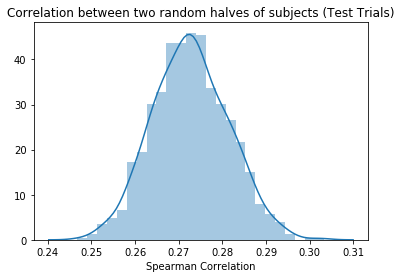

In [131]:
sns.distplot(test_corrs)
plt.title("Correlation between two random halves of subjects (Test Trials)")
plt.xlabel("Spearman Correlation")

In [141]:
shared_corrs = []
for _ in range(1000):
    half_1 = []
    half_2 = []
    for l in shared_matrices:
        word_responses = np.array(shared_matrices[l])
        n = len(word_responses)
        if n % 2 == 1:
            drop_one = np.random.choice(np.arange(n), n - 1, replace=False)
            word_responses = word_responses[drop_one]
        n = len(word_responses)
        half = int(n / 2)
        shuffled_indices = np.random.choice(np.arange(n), n, replace = False)
        half_1 += list(word_responses[shuffled_indices[:half]])
        half_2 += list(word_responses[shuffled_indices[half:]])
    shared_corrs.append(mtx_correlation(half_1, half_2, method = 'spearman'))

Text(0.5, 0, 'Spearman Correlation')

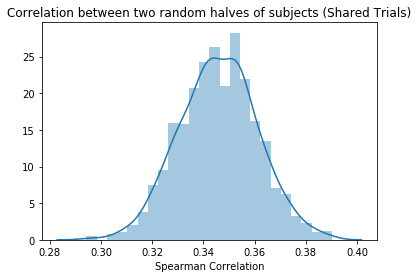

In [142]:
sns.distplot(shared_corrs)
plt.title("Correlation between two random halves of subjects (Shared Trials)")
plt.xlabel("Spearman Correlation")

## Tagging Homonymous Senses

In [5]:
import itertools

0 is homonymous, 1 is polysemous

In [29]:
hp_tags = []
homonyms = [('foot_n_01', 'foot_n_02'), ('foot_n_02', 'foot_n_03'), ('table_n_01', 'table_n_02'), ('table_n_02', 'table_n_03'),
            ('academic_degree_n_01', 'degree_n_01'), ('academic_degree_n_01', 'degree_n_02'), ('right_n_01', 'right_n_02'),
            ('right_n_01', 'right_n_04'), ('model_n_02', 'model_n_03'), ('model_n_01', 'model_n_03')]
for s in results[results['trialType'] != 'training']['lemma'].unique():
    sense_combos = list(itertools.combinations(get_senses(db, s), 2))
    for t in sense_combos:
        if t in homonyms:
            hp_tags.append({'item': t, 'word_type': s, 'relation_type': 'homonymous'})
        else:
            hp_tags.append({'item': t, 'word_type': s, 'relation_type': 'polysemous'})


In [30]:
df = []
for w in results[results['trialType'] != 'training']['lemma'].unique():
    pair_results = results[(results['userID'].isin(incl_users)) & (results['lemma'] == w)]
    for u in pair_results['userID'].unique():
        max_user_dist = 0
        user_reported_distances = []
        word_pairs = [t for t in hp_tags if t['word_type'] == w]
        for t in word_pairs:
            user_report = pair_results[(pair_results['trialType'] != 'training') & (pair_results['userID'] == u) & \
                    (pair_results['lemma'] == t['word_type']) & (pair_results['sense'].isin(t['item']))]
            user_report = user_report.reset_index()
            dist = calculate_distance(user_report.iloc[0], user_report.iloc[1])
            if dist > max_user_dist:
                max_user_dist = dist
            row = t.copy()
            row['dist'] = dist
            row['user'] = u
            user_reported_distances.append(row)
        for d in user_reported_distances:
            d['dist'] = d['dist'] / max_user_dist
        df += user_reported_distances


In [35]:
df = pd.DataFrame(df)
df.to_csv("../data/sense_pair_distances.csv", index = False)

In [14]:
df.columns

Index(['item', 'word_type', 'relation_type', 'dist', 'user'], dtype='object')

In [36]:
df['relation_type'].value_counts()

polysemous    5584
homonymous     940
Name: relation_type, dtype: int64

Text(0, 0.5, 'Ass')

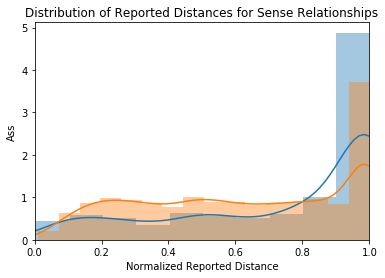

In [40]:
hom_dist = df[df['relation_type'] == 'homonymous']['dist']
pol_dist = df[df['relation_type'] == 'polysemous']['dist']
sns.distplot(hom_dist, label = 'Homonymous')
sns.distplot(pol_dist, label = 'Polysemous')
plt.title("Distribution of Reported Distances for Sense Relationships")
plt.xlim(0, 1)
plt.xlabel("Normalized Reported Distance")
plt.ylabel("Ass")

In [41]:
from scipy import stats

In [57]:
stats.mannwhitneyu(hom_dist, pol_dist)

MannwhitneyuResult(statistic=1959176.5, pvalue=3.518772011507835e-36)

## Sense Definitions for Presentation/Paper

In [20]:
all_test_defs = display_sense_definitions(results, 'test')

In [70]:
all_test_defs[all_test_defs['Type'] == 'world_n']

,Sense,Type,Definition
242,earth_n_01,world_n,the 3rd planet from the sun; the planet we live on
243,populace_n_01,world_n,people in general considered as a whole
244,universe_n_01,world_n,everything that exists anywhere
245,world_n_02,world_n,people in general; especially a distinctive group of people with some shared interest
246,world_n_03,world_n,all of your experiences that determine how things appear to you


In [72]:
all_test_defs[all_test_defs['Type'] == 'light_n']

,Sense,Type,Definition
425,light_n_01,light_n,(physics) electromagnetic radiation that can produce a visual sensation
426,light_n_02,light_n,any device serving as a source of illumination
427,light_n_03,light_n,a particular perspective or aspect of a situation


In [37]:
fig_words = all_test_defs[all_test_defs['Type'].isin(['world_n', 'indicate_v', 'lead_v', 'life_n'])]
fig_words['Sense'] = fig_words['Sense'].apply(lambda s: s.replace('_', '.'))
fig_words['Type'] = fig_words['Type'].apply(lambda s: s.replace('_', '.'))

#fig_words.to_csv('../data/scatter_defns.csv', index = False)

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
fig_words = all_test_defs[all_test_defs['Type'].isin(['put_v', 'cover_v', 'point_n', 'consider_v', 'raise_v'])]
fig_words['Sense'] = fig_words['Sense'].apply(lambda s: s.replace('_', '.'))
fig_words['Type'] = fig_words['Type'].apply(lambda s: s.replace('_', '.'))
#fig_words.to_csv('../data/conf_words.csv', index = False)

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
fig_words[fig_words['Type'] == 'raise.v'].to_latex(index = False)

'\\begin{tabular}{lll}\n\\toprule\n      Sense &     Type &                                    Definition \\\\\n\\midrule\n raise.v.01 &  raise.v &        raise the level or amount of something \\\\\n raise.v.02 &  raise.v &       raise from a lower to a higher position \\\\\n raise.v.03 &  raise.v &  cause to be heard or known; express or utter \\\\\n raise.v.04 &  raise.v &          collect funds for a specific purpose \\\\\n\\bottomrule\n\\end{tabular}\n'